A quick python parser for the data from the excellent website https://energy-charts.info/index.html?l=en&c=UK

In [1]:
import pandas as pd
from datetime import datetime
import requests
import json
import matplotlib.pyplot as plt
from ast import literal_eval as make_tuple
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
def plot_prod(country='de', step='day', year='2021', lang='en', load=True, display=True, cumul=False, rolling=False):
    
    s = requests.Session()
    
    if not (country == 'de' and int(year) < 2019):
        url = f'https://energy-charts.info/charts/energy/data/{country}/{step}_{year}.json'
    else:
        url = f'https://energy-charts.info/charts/energy/raw_data/{country}/{step}_{year}.json'
    print(url)
    r = s.get(url)
    
    s.close()
    
    response = json.loads(r.text)
    
    try:
        techs = [r['name'][0][lang] for r in response]
    except KeyError:
        techs = [r['name'][lang] for r in response]
    
    prod  = [r['data'] for r in response]
    ticks = [datetime.strptime(d, '%d.%m.%Y') for d in response[0]['xAxisValues']]
    colors = {t:tuple(c/255 for c in make_tuple(r['color'][3:])) for r,t in zip(response,techs)}
    colors = {**colors, **{'_'+k:v for k,v in colors.items()}}
    load_dict = {'en': 'Load', 'de': 'Last', 'fr': 'Charge', 'it': 'Carico'}
    
    prod_df = pd.DataFrame(data=prod,
                      index=techs,
                      columns=ticks).T
    
    if rolling:
        prod_df = prod_df.rolling(rolling).sum()
    
    if cumul:
        prod_df = prod_df.cumsum()
        
    load_df = prod_df[load_dict[lang]]
    prod_df.drop(load_dict[lang], axis=1, inplace=True)
    
    if display:
        fig, ax = plt.subplots(figsize=(20,10), facecolor='w')
        # split dataframe df into negative only and positive only values
        df_neg, df_pos = prod_df.clip(upper=0), prod_df.clip(lower=0)
        # stacked area plot of positive values
        prod_plt = df_pos.plot.area(ax=ax,
                         stacked=True,
                         linewidth=0.,
                         color=colors)
        # stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
        df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, linewidth=0., color=colors)

        if load:
            load_plt = load_df.plot(ax=ax,
                         linewidth=2,
                         color=colors[load_dict[lang]])
            handles, labels = ax.get_legend_handles_labels()
            
            plt.legend(handles=handles, loc='upper center')

        # rescale the y axis
        ax.set_ylim([df_neg.sum(axis=1).min()*1.1, df_pos.sum(axis=1).max()*1.1])
        
        
    return prod_df, load_df

https://energy-charts.info/charts/energy/data/fi/day_2021.json


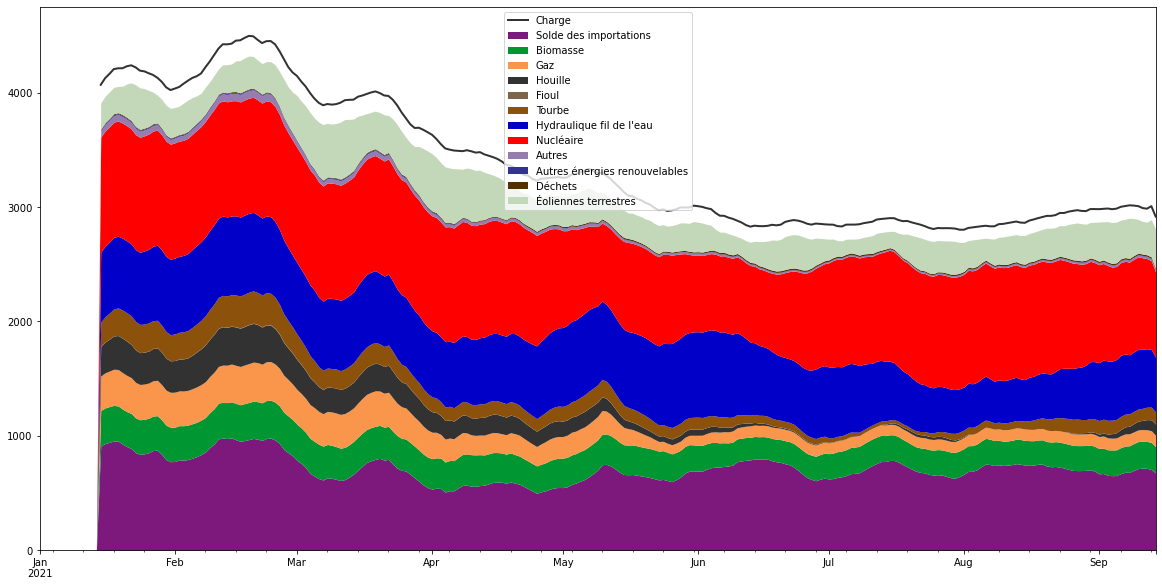

In [16]:
prod_df, load_df = plot_prod(country='fi',
                             year='2021',
                             display=True,
                             load=True,
                             rolling=15,
                             lang='fr')

In [17]:
all_prods = dict()

In [21]:
for country in ['de','it','fr','pl']:
    all_prods[country] = dict()
    for year in ['2019','2020','2021']: 
        all_prods[country][year], _ = plot_prod(country=country, year=year, display=False, load=False)

https://energy-charts.info/charts/energy/data/de/day_2019.json
https://energy-charts.info/charts/energy/data/de/day_2020.json
https://energy-charts.info/charts/energy/data/de/day_2021.json
https://energy-charts.info/charts/energy/data/it/day_2019.json
https://energy-charts.info/charts/energy/data/it/day_2020.json
https://energy-charts.info/charts/energy/data/it/day_2021.json
https://energy-charts.info/charts/energy/data/fr/day_2019.json
https://energy-charts.info/charts/energy/data/fr/day_2020.json
https://energy-charts.info/charts/energy/data/fr/day_2021.json
https://energy-charts.info/charts/energy/data/pl/day_2019.json
https://energy-charts.info/charts/energy/data/pl/day_2020.json
https://energy-charts.info/charts/energy/data/pl/day_2021.json


In [22]:
columns_agg = {'Hydro pumped storage consumption': 'Hydro pumped storage consumption',
               'Import Balance': 'Import balance',
               'Biomass': 'Biomass',
               'Fossil gas': 'Fossil gas',
               'Fossil oil': 'Fossil oil',
               'Hydro pumped storage': 'Hydro pumped storage generation',
               'Hydro Run-of-River': 'Hydro run-of-river',
               'Nuclear': 'Nuclear',
               'Others': 'Others',
               'Solar': 'Solar',
               'Waste': 'Waste',
               'Wind offshore': 'Wind',
               'Wind onshore': 'Wind',
               'Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Hydro Power': 'Hydro',
               'Uranium': 'Nuclear',
               'Brown Coal': 'Brown coal',
               'Hard Coal': 'Hard coal',
               'Oil': 'Fossil oil',
               'Gas': 'Fossil gas',
               'Pumped Storage generation': 'Hydro pumped storage generation',
               'Wind': 'Wind',
               'Hydro Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Fossil Brown Coal': 'Brown coal',
               'Fossil Hard Coal': 'Hard coal',
               'Fossil Oil': 'Fossil oil',
               'Fossil Gas': 'Fossil gas',
               'Hydro Pumped Storage generation': 'Hydro pumped storage generation',
               'Hydro Water Reservoir': 'Hydro',
               'Fossil hard coal': 'Hard coal'}

In [23]:
raw_agg = pd.concat([pd.concat(p, axis=0) for p in all_prods.values()], keys=all_prods.keys())
prod_agg = raw_agg.groupby(columns_agg, axis=1).sum()
prod_agg.index.names=('country','year','date')
prod_agg = prod_agg.reset_index()
prod_agg['day of year'] = prod_agg['date'].dt.dayofyear
prod_agg = prod_agg.drop('date',axis=1)
# prod_agg = prod_agg.drop('date')
prod_agg = prod_agg.set_index(['day of year','year','country']).unstack(['year','country'])
prod_agg = prod_agg.reorder_levels(order=[2,1,0],axis=1)
prod_agg['de','2019']*=1000

In [24]:
prod_agg[prod_agg==0] = np.nan

In [25]:
countries = prod_agg.columns.levels[0]
countries

Index(['de', 'dk', 'fr', 'it', 'pl'], dtype='object', name='country')

In [26]:
colors =  [ (r/255,g/255,b/255) for r,g,b in
           [
            (169,169,169), (128,128,128), (105,105,105),
             (102,102,255),(51,51,255),(0,0,255),
             (51,255,153),(0,255,128),(0,204,102),
            (255,128,0), (255,153,51) , (255,178,102),
               (238, 238, 105), (181, 179, 81), (157, 155, 71),
            (211, 52, 93), (231, 26, 47), (250, 0, 0),
           ]]


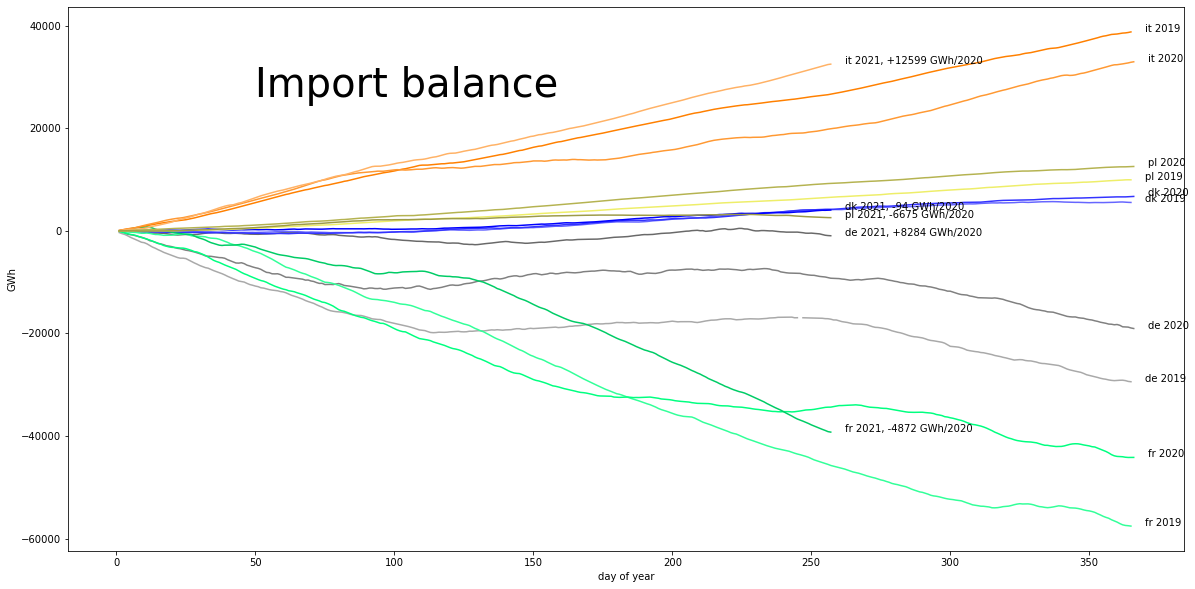

In [29]:
tech = 'Import balance'

cumul = prod_agg.loc[:,([c for c in countries if c not in ['es','be','nl']],slice(None),tech)].cumsum(skipna=True)
# cumul = cumul.groupby('year', axis=1).sum()
fig, ax = plt.subplots(figsize=(20,10), facecolor='w')

cumul.plot(color=colors, ax=ax)
for c in cumul.columns:
    last_v = cumul[c].last_valid_index()
    
    if c[1] == '2021':
        v_2020 = cumul.loc[last_v,(c[0], '2020', tech)]
        gap = cumul[c][last_v] - v_2020 
        label = f'{c[0]} {c[1]}, {gap:+0.0f} GWh/2020'
    else:
        label = f'{c[0]} {c[1]}'
        
    plt.text(cumul[c].last_valid_index() + 5,
             cumul[c][cumul[c].last_valid_index()],
             label)
plt.text(50, ax.get_ylim()[1] * .6, tech, fontsize=40)
ax.set_ylabel('GWh')
ax.get_legend().remove()